In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

np.random.seed(2)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import (
    Dense, Dropout, Flatten, Conv2D, MaxPool2D
)
from keras.optimizers import rmsprop_v2
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

import tensorflow as tf

sns.set(style='white', context='notebook', palette='deep')

In [68]:
# this disable the GPU
# tf.config.set_visible_devices([], 'GPU')
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


# 1. Data preparation
## 1.1 Loading data

In [69]:
train = pd.read_csv('./input/train.csv')
test = pd.read_csv('./input/test.csv')

/home/lievisilva/.cache/pypoetry/virtualenvs/cnn-mnist-3oAv3CAk-py3.9/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


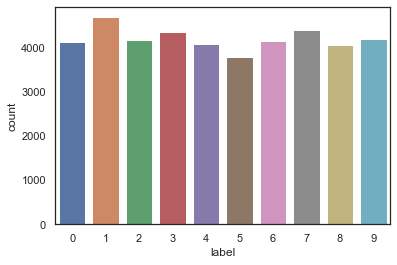

In [70]:
# getting the label (the "response") from the train data
Y_train = train['label']

# removing the label from the train data
X_train = train.drop(labels=["label"], axis=1)

# showing the quantity of labels on the train dataset
g = sns.countplot(Y_train)

## 1.2 Normalization

In [71]:
# verifying if there is any null value
X_train.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

In [72]:
# Transforming the data, that is of range [0..255],
# to [0..1]
X_train = X_train / 255.0
test = test / 255.0

## 1.3 Reshaping

Reshaping the images will transform the pandas `Dataframe` 1D vector of 764 values, into a `np.array` matrix, with 28x28x1(the 1 is the "color channel", in this case, the images is grayscale)

In [73]:
# Reshaping the images in 3 dimensions(height 28px, width 28px, canal 1(grayscale))
X_train = X_train.values.reshape(-1, 28, 28, 1)
test = test.values.reshape(-1, 28, 28, 1)

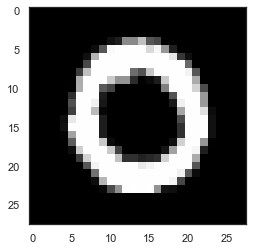

In [74]:
# Plotting the image
g = plt.imshow(X_train[1], cmap='gray')

## 1.4 Label encoding

Is basically transform the Y value, that is what digit the image X is(e.g: 3 or 9), to a vector of the size of all the possible values. All the values will be 0, except for the index of the right value.

E.g: If the y value is 3, the vector will be `[0, 0, 1, 0, 0, 0, 0, 0, 0, 0]`

In [75]:
print(f"before:{Y_train[76]}")

before:7


In [76]:
Y_train = to_categorical(Y_train, num_classes=10)
print(f"after: {Y_train[76]}")

after: [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]


## 1.5 Splitting train and validation data

In [77]:
random_seed = 2

In [78]:
X_train, X_val, Y_train, Y_val = train_test_split(
    X_train, Y_train, test_size=0.1, random_state=random_seed
)

# 2 CNN
## 2.1 Define the model

### Convolutional layer
* On the convolution layer, we have a set of filter, with a kernel size(in this network, we're using 5x5 `kernel_size`, and 32 `filters`, there are  hyperparameters). 
* Each filter will learn(as the network backpropagates) to find some "filters" on the image, like a vertical line, or a horizontal line.
* These filters will run over the image, trying to "recognize" the filter on the entire image
  * Each filter is basically a set of shared weights, that will calculate w * x (input layer) + bias, and will learn over time how to change the values of the weights and bias to minimize the error.
* The result of this calculation will them connect to the hidden layer, and after that, calculate the output layer
- ![Cnn Example](./images/cnn_example.png)
- ![Another CNN example](./images/cnn_example_2.png)
* This will help to deacrease the numbers of features that need to be processed
* The convolutional layer also has a resistence to overfit, because it's use the shared weights to "learn" a filter on the entire image, so is less likely to them pick up some idiosyncrasies

### Pooling layer
- The max-pooling layer takes the output from the convolutional layer, and them "simplify" this combining a certain number of pixels(this can be configured)
- As a example using max-pooling, and a input region of `2x2`, with a `24x24` output from the convolutional layer
  - ![Max-Pooling example](./images/max_pooling.png)
  - The layer will verify a combination of 4 pixels(2x2), and get the maximal value of these 4 values
  - So, the 24x24 output, became a 12x12
- This help to reduce the computational cost, because the quantity of parameters will be smaller, help to reduce overfitting, 
- Combining the convolutional and pooling layer helps the network to learn more global features of the image, instead of local features.

### Dropout layer
- The dropout layer randomly ignore some nodes(set the weights to zero) on the layer for each training example.
- This forces the network to learn features in a distributed way, and also helps on the generalization and reduce the overfitting
- ? Apparently, you can put the dropout layer after the maxpooling, or on the dense layer
  - [stackoverflow question](https://stackoverflow.com/questions/47701544/does-dropout-layer-go-before-or-after-dense-layer-in-tensorflow)
  - [reddit questioning](https://www.reddit.com/r/MachineLearning/comments/42nnpe/why_do_i_never_see_dropout_applied_in/)
  - Try remove, put only on after the maxpooling and on both after the maxpooling and after the dense layer

### Dense layers
- The dense layer is a "normal" neural network, that will calculate the weighted value using the input, weight and bias.
- And them calculate the error, and will try to decrease that error by changing the weights and bias.

- The first dense layer is using the relu activation funtion

- The output layer is using the softmax, that interpret the output activation as propabilities. 
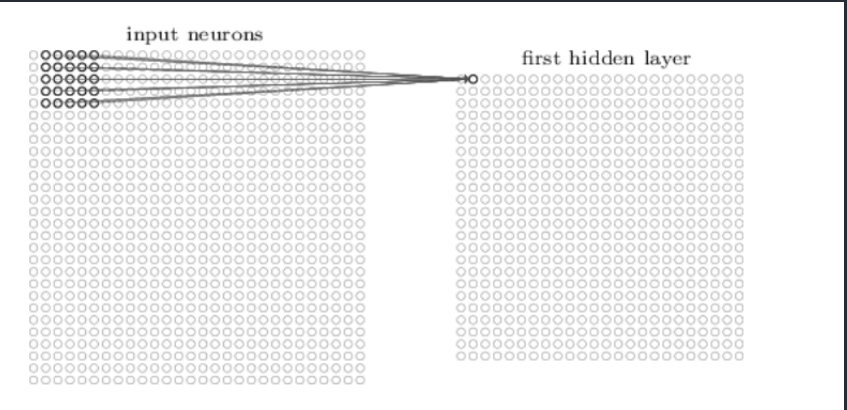
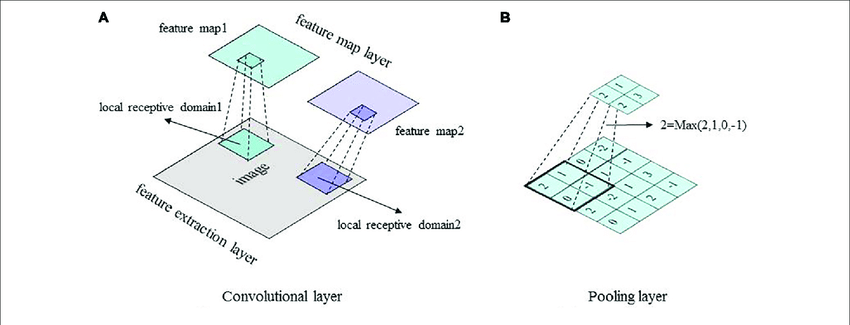

In [136]:
model = Sequential()

model.add(
    Conv2D(
        filters=32,
        kernel_size=(5, 5),
        padding="Same",
        activation='relu',
        input_shape=(28, 28, 1)
    )
)
model.add(
    Conv2D(
        filters=32,
        kernel_size=(5, 5),
        padding="Same",
        activation='relu',
    )
)
model.add(
    MaxPool2D(pool_size=(2, 2))
)
model.add(Dropout(0.25))

model.add(
    Conv2D(
        filters=64,
        kernel_size=(3, 3),
        padding="Same",
        activation='relu'
    )
)
model.add(
    Conv2D(
        filters=64,
        kernel_size=(3, 3),
        padding="Same",
        activation='relu'
    )
)
model.add(
    MaxPool2D(pool_size=(2, 2), strides=(2, 2))
)
model.add(Dropout(0.25))

# Flattening the matrix into a vector
model.add(Flatten())
model.add(Dense(256, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation="softmax"))

## 2.2 Optimizer

- We need to set up a keras optimizer, and choose the _score function_(?) a _loss function_(such as mean squared error) and a _optimization function_(like gradient descent, or stochastic gradient descent) 
- *Keras* has a set of objects that implement these optimizers.

In [142]:
# Hyperparamenters
epochs = 30
batch_size = 30
learning_rate=0.001
rho=0.9
epsilon=1e-08
decay=0.0

In [137]:
# TODO: implement other types of optimizers to see the difference betweem them
# TODO: learn about the RMSProp
optimizer = rmsprop_v2.RMSProp(
     rho=rho, epsilon=epsilon, decay=decay
)

In [143]:
# TODO: use other types of loss functions and compare the accuracy
model.compile(
    optimizer=optimizer,
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

We're gonna use the `ReduceLROnPlateau` callback.

This class dynamically deacrese the _learning rate_ as the loss came to certain plateou.

This will increase the speed to the learning, because at the beginning we make large steps down the "hill", and as the network learns, we deacrease this number to improve the accuracy

In [117]:
learning_rate_reduction = ReduceLROnPlateau(
    monitor='loss',
    patience=3,
    verbose=1,
    factor=0.5,
    min_lr=0.00001
)


## Data Augmentation
- Is artificially expand the data that we have, creating new variations from the existing ones
- On the mnist problem, where the input data is images, we can rotate, scale, decentralize the image to create a slightly different image
- We're gonna use the `ImageDataGenerator` from keras, to create artificial data

In [118]:
datagen = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=10, # randomly rotate the image
    zoom_range=0.1, # randomly zoom the image
    width_shift_range=0.1, # randomly shift image horizontally
    height_shift_range=0.1, # randomly shilft images
    vertical_flip=False, # randomly flip the image
)

datagen.fit(X_train)

In [119]:
# the fit fn will train the model, and return an History object
history = model.fit(
    x=X_train,
    y=Y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_val, Y_val),
    steps_per_epoch=X_train.shape[0] // batch_size,
    callbacks=[learning_rate_reduction]
)

Epoch 1/10
1260/1260 [==============================] - 4s 3ms/step - loss: 0.0567 - accuracy: 0.9845 - val_loss: 0.0656 - val_accuracy: 0.9850
Epoch 2/10
1260/1260 [==============================] - 3s 3ms/step - loss: 0.0536 - accuracy: 0.9847 - val_loss: 0.0647 - val_accuracy: 0.9850
Epoch 3/10
1260/1260 [==============================] - 3s 3ms/step - loss: 0.0545 - accuracy: 0.9851 - val_loss: 0.0667 - val_accuracy: 0.9852
Epoch 4/10
1260/1260 [==============================] - 3s 2ms/step - loss: 0.0530 - accuracy: 0.9855 - val_loss: 0.0655 - val_accuracy: 0.9852
Epoch 5/10
1260/1260 [==============================] - 3s 2ms/step - loss: 0.0493 - accuracy: 0.9858 - val_loss: 0.0663 - val_accuracy: 0.9857
Epoch 6/10
1260/1260 [==============================] - 3s 3ms/step - loss: 0.0511 - accuracy: 0.9861 - val_loss: 0.0651 - val_accuracy: 0.9852
Epoch 7/10
1260/1260 [==============================] - 3s 2ms/step - loss: 0.0502 - accuracy: 0.9856 - val_loss: 0.0653 - val_accuracy:

In [144]:
history_datagen = model.fit(
    datagen.flow(
        X_train, Y_train, batch_size=batch_size
    ),
    epochs=epochs,
    validation_data=(X_val, Y_val),
    verbose=1,
    steps_per_epoch=X_train.shape[0] // batch_size,
    callbacks=[learning_rate_reduction]
)

Epoch 1/30
1260/1260 [==============================] - 10s 7ms/step - loss: 0.0757 - accuracy: 0.9807 - val_loss: 0.0296 - val_accuracy: 0.9924
Epoch 2/30
1260/1260 [==============================] - 9s 7ms/step - loss: 0.0792 - accuracy: 0.9791 - val_loss: 0.0513 - val_accuracy: 0.9883
Epoch 3/30
1260/1260 [==============================] - 9s 7ms/step - loss: 0.0810 - accuracy: 0.9801 - val_loss: 0.0476 - val_accuracy: 0.9907
Epoch 4/30
1260/1260 [==============================] - 9s 7ms/step - loss: 0.0841 - accuracy: 0.9789 - val_loss: 0.0477 - val_accuracy: 0.9890

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 5/30
1260/1260 [==============================] - 9s 7ms/step - loss: 0.0663 - accuracy: 0.9822 - val_loss: 0.0500 - val_accuracy: 0.9898
Epoch 6/30
1260/1260 [==============================] - 9s 7ms/step - loss: 0.0673 - accuracy: 0.9833 - val_loss: 0.0458 - val_accuracy: 0.9893
Epoch 7/30
1260/1260 [==============================] 

In [122]:
# using mean squared error as loss fn
model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.MeanSquaredError(),
    metrics=["accuracy"]
)
# i think that MSE not make sense because it is a regression loss
# TODO: verify if make sense
history_mse = model.fit(
    datagen.flow(
        X_train, Y_train, batch_size=batch_size
    ),
    epochs=epochs,
    validation_data=(X_val, Y_val),
    verbose=1,
    steps_per_epoch=X_train.shape[0] // batch_size,
    callbacks=[learning_rate_reduction]
)

Epoch 1/10
1260/1260 [==============================] - 9s 7ms/step - loss: 0.0097 - accuracy: 0.9374 - val_loss: 0.0037 - val_accuracy: 0.9783
Epoch 2/10
1260/1260 [==============================] - 9s 7ms/step - loss: 0.0098 - accuracy: 0.9371 - val_loss: 0.0035 - val_accuracy: 0.9793
Epoch 3/10
1260/1260 [==============================] - 9s 7ms/step - loss: 0.0100 - accuracy: 0.9346 - val_loss: 0.0036 - val_accuracy: 0.9786
Epoch 4/10
1260/1260 [==============================] - 9s 7ms/step - loss: 0.0097 - accuracy: 0.9379 - val_loss: 0.0036 - val_accuracy: 0.9786
Epoch 5/10
1260/1260 [==============================] - 9s 7ms/step - loss: 0.0095 - accuracy: 0.9388 - val_loss: 0.0036 - val_accuracy: 0.9783
Epoch 6/10
1260/1260 [==============================] - 9s 7ms/step - loss: 0.0093 - accuracy: 0.9401 - val_loss: 0.0036 - val_accuracy: 0.9786
Epoch 7/10
1260/1260 [==============================] - 9s 7ms/step - loss: 0.0094 - accuracy: 0.9400 - val_loss: 0.0037 - val_accuracy:

## Evaluating the network
- Showing the result with the simplest network architecture and with no data augmentation

In [104]:
def plot_accuracy_and_loss(history):

    fig, ax = plt.subplots(2, 1)
    ax[0].plot(
        history.history['loss'],
        color='b',
        label='Training Loss'
    )
    ax[0].plot(
        history.history['val_loss'],
        color='r',
        label='Validation Loss'
    )
    legend = ax[0].legend(loc='best')

    ax[1].plot(
        history.history['accuracy'],
        color='b',
        label="Training Accuracy"
    )
    ax[1].plot(
        history.history['val_accuracy'],
        color='r',
        label="Validation Accuracy"
    )
    legend = ax[1].legend(loc='best')

    print(
        f"Best accuracy: {max(history.history['accuracy']):.6f}"
    )
    print(
        "Best validation accuracy"
        f": {max(history.history['val_accuracy']):.6f}"
    )

Best accuracy: 0.986111
Best validation accuracy: 0.985714


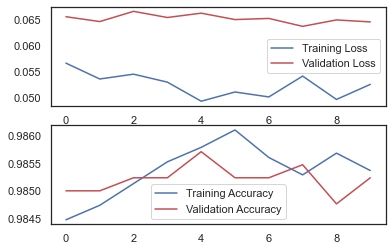

In [123]:
plot_accuracy_and_loss(history)

- Using the data augmentation generator to increase the data

Best accuracy: 0.938175
Best validation accuracy: 0.981429


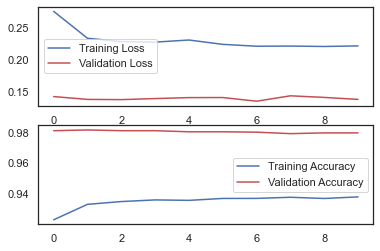

In [124]:
plot_accuracy_and_loss(history_datagen)

Best accuracy: 0.940635
Best validation accuracy: 0.979286


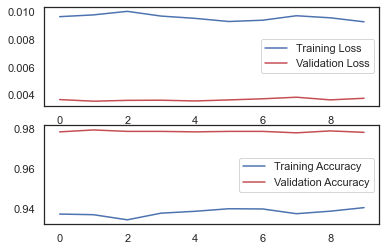

In [125]:
plot_accuracy_and_loss(history_mse)

- Using 2 convolutional layer at the begin

Best accuracy: 0.894259
Best validation accuracy: 0.964762


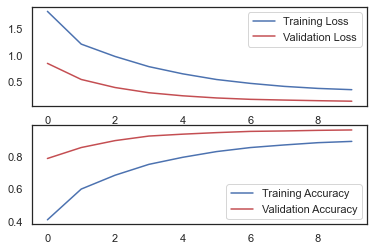

In [129]:
plot_accuracy_and_loss(history_datagen)

- Using kaggle example:
    - two conv 2d layers
    - one maxpool
    - dropout
    - two conv 2d again
    - max pool
    - dropout
    - hidden layer
    - output layer

Best accuracy: 0.987487
Best validation accuracy: 0.992381


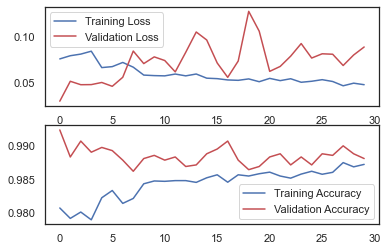

In [145]:
plot_accuracy_and_loss(history_datagen)